# LM Evaluation Harness Results Visualization

This notebook visualizes the results from the LM Evaluation Harness, comparing different models across various benchmarks.

In [41]:
# !pip install pandas matplotlib seaborn 

In [42]:
import glob
import json
import os
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Set plot style
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 12

## Load Results

First, we'll load all the result files from the outputs directory.

In [43]:
# Define the path to the outputs directory
outputs_dir = Path("../outputs")

# Find all model directories
model_dirs = [d for d in outputs_dir.iterdir() if d.is_dir()]
print(f"Found {len(model_dirs)} model directories: {[d.name for d in model_dirs]}")

# Function to load result files
def load_results(model_dir):
    results_files = list(model_dir.glob("results_*.json"))
    all_results = []
    
    for file_path in results_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                
            # Extract model name
            model_name = model_dir.name
            
            # Extract tasks and their results
            for task_name, task_results in data['results'].items():
                benchmark, fs = task_name.split('_cot_', 1)
                n_shot = data['configs'][task_name]['num_fewshot']
                prompting = f"COT-{n_shot}"

                # Get the best metric (usually the one with flexible-extract)
                metrics = {k: v for k, v in task_results.items() if not k == 'alias'}
                
                result_entry = {
                    'model': model_name,
                    'benchmark': benchmark,
                    'prompting': prompting,
                    'n_shot': n_shot,
                    **metrics,
                }
                
                all_results.append(result_entry)
                
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return all_results

# Load all results
all_results = []
for model_dir in model_dirs:
    model_results = load_results(model_dir)
    all_results.extend(model_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df['score'] = results_df['exact_match,flexible-extract']

# Display basic info
print(f"Loaded {len(results_df)} result entries")
results_df.head()

Found 2 model directories: ['qwen-2.5-1.5b', 'llama-3-8b']
Loaded 10 result entries


,model,benchmark,prompting,n_shot,"exact_match,strict-match","exact_match_stderr,strict-match","exact_match,flexible-extract","exact_match_stderr,flexible-extract",score
0,qwen-2.5-1.5b,gpqa_diamond,COT-1,1,0.000000,0.000000,0.242424,0.030533,0.242424
1,qwen-2.5-1.5b,gsm8k,COT-0,0,0.000000,0.000000,0.667172,0.012980,0.667172
2,qwen-2.5-1.5b,gsm8k,COT-8,8,0.671721,0.012935,0.671721,0.012935,0.671721
3,qwen-2.5-1.5b,gpqa_diamond,COT-0,0,0.000000,0.000000,0.287879,0.032259,0.287879
4,qwen-2.5-1.5b,gpqa_main,COT-0,0,0.000000,0.000000,0.234375,0.020036,0.234375


## Create Summary Table

Let's create a summary table that shows the performance of each model on each task.

In [44]:
# Create a pivot table with benchmarks on rows, models on columns, and tasks grouped by benchmark
# First, create a multi-index with benchmark and prompting
results_with_index = results_df.copy()
results_with_index['benchmark_prompting'] = results_df.apply(
    lambda row: (row['benchmark'], row['prompting']), axis=1
)

# Create the pivot table
summary_table = results_with_index.pivot_table(
    index='benchmark_prompting',
    columns='model',
    values='score',
    aggfunc='max'  # In case there are multiple entries for the same model-task pair
)

# Reset the index to get benchmark and prompting as separate columns
summary_table = summary_table.reset_index()
summary_table[['benchmark', 'prompting']] = pd.DataFrame(summary_table['benchmark_prompting'].tolist(), index=summary_table.index)
summary_table = summary_table.drop('benchmark_prompting', axis=1)

# Set benchmark and prompting as index for grouping
summary_table = summary_table.set_index(['benchmark', 'prompting'])

# Highlight the best model for each prompting
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

styled_table = summary_table.style\
    .format("{:.1%}")\
    .apply(highlight_max, axis=1)\
    .set_caption("Model Performance (higher is better)")

styled_table

## Visualize Results

Now let's create some visualizations to better understand the results.

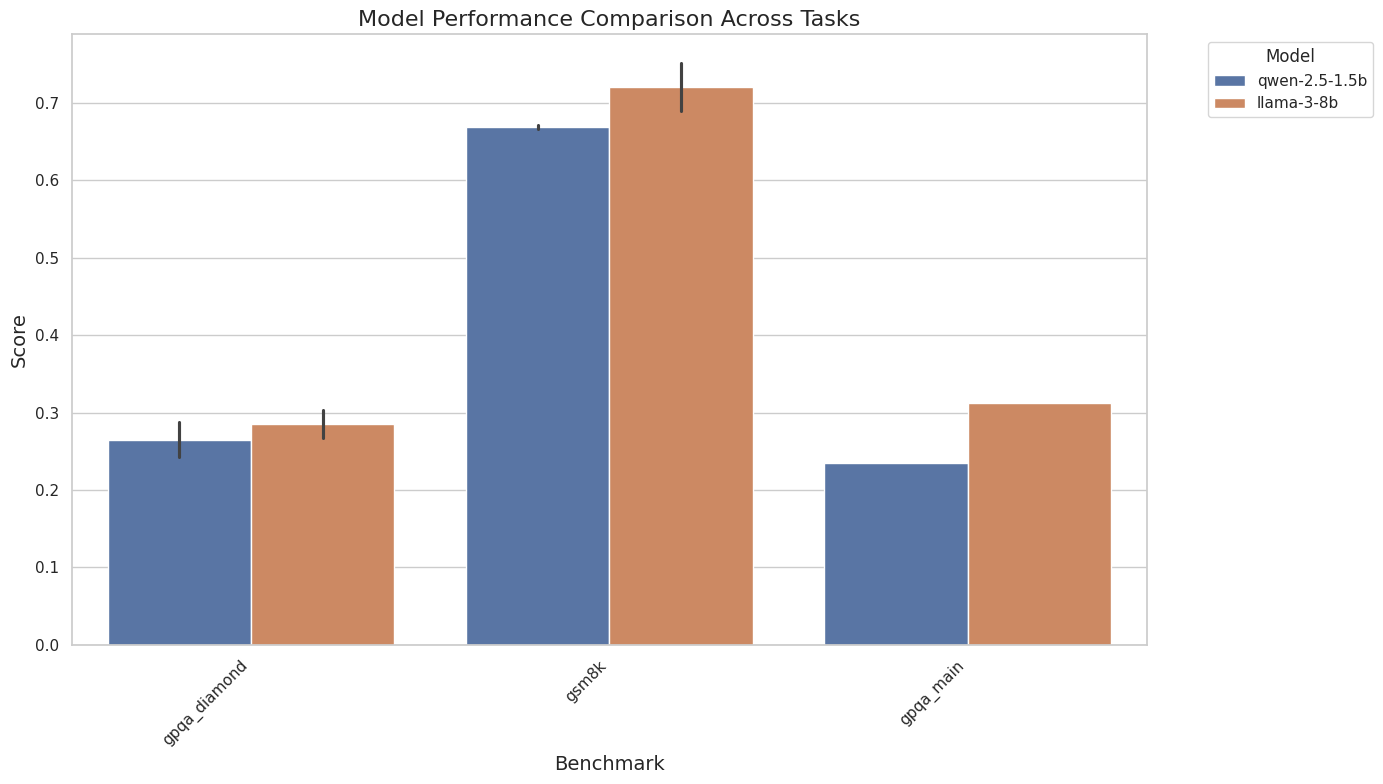

In [45]:
# Bar chart comparing models across tasks
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='benchmark', y='score', hue='model', data=results_df)
plt.title('Model Performance Comparison Across Tasks', fontsize=16)
plt.xlabel('Benchmark', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

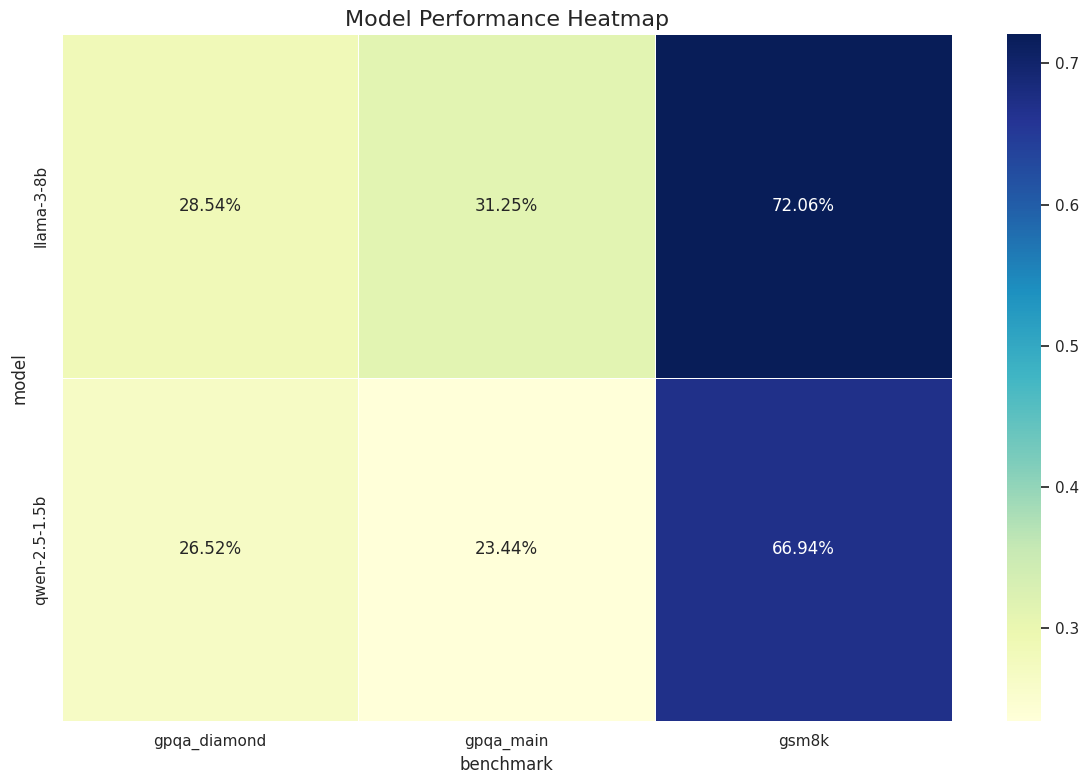

In [46]:
# Heatmap of model performance
plt.figure(figsize=(12, 8))
pivot_data = results_df.pivot_table(index='model', columns='benchmark', values='score')
sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.2%', linewidths=.5)
plt.title('Model Performance Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## Radar Chart for Model Comparison

Let's create a radar chart to compare models across different tasks.

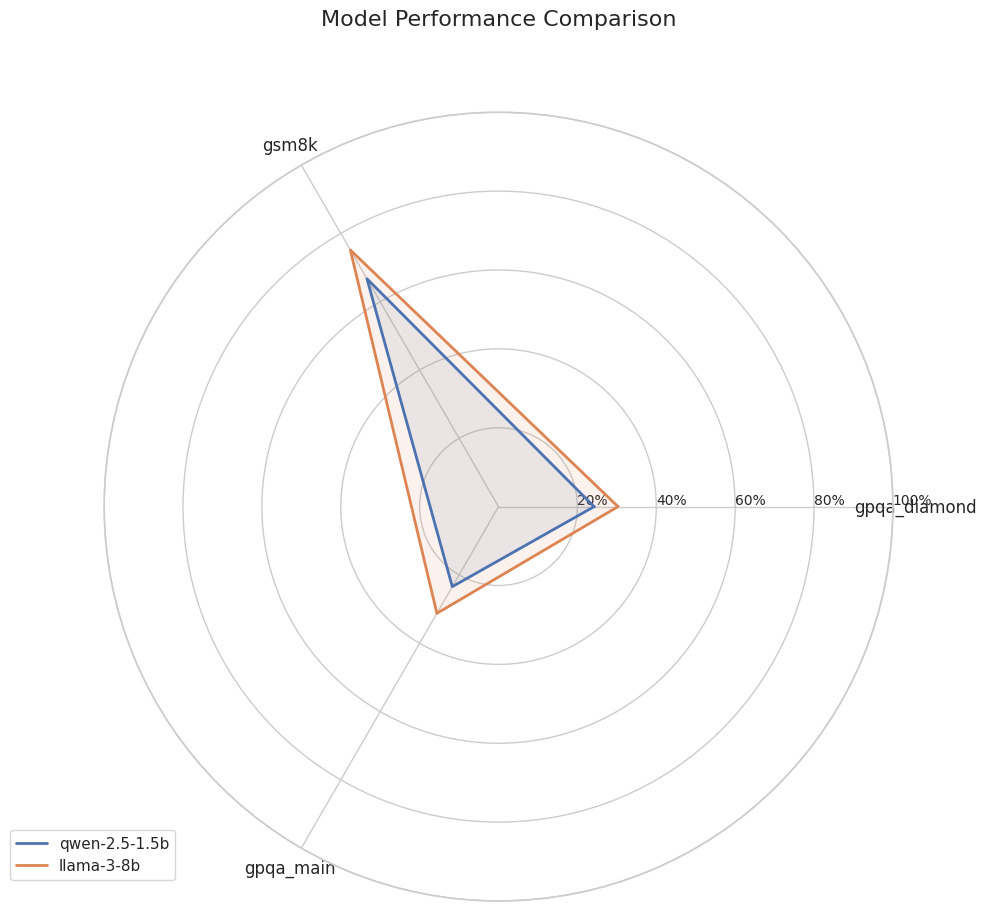

In [47]:
# Function to create a radar chart
def radar_chart(df, value_col, title):
    # Get the categories and models
    categories = df['benchmark'].unique()
    models = df['model'].unique()
    
    # Number of categories
    N = len(categories)
    
    # Create angles for each category
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Add category labels
    plt.xticks(angles[:-1], categories, fontsize=12)
    
    # Set y-ticks
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"], fontsize=10)
    plt.ylim(0, 1)
    
    # Plot each model
    for i, model in enumerate(models):
        model_data = df[df['model'] == model]
        values = []
        
        # Get values for each category
        for cat in categories:
            cat_data = model_data[model_data['benchmark'] == cat]
            if not cat_data.empty:
                values.append(cat_data[value_col].values[0])
            else:
                values.append(0)
        
        # Close the loop
        values += values[:1]
        
        # Plot the model data
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title, fontsize=16, y=1.1)
    
    return fig

# Create radar chart
radar_fig = radar_chart(results_df, 'score', 'Model Performance Comparison')
plt.tight_layout()
plt.show()

## Export Results

Let's export the summary table to a CSV file for further analysis.

In [48]:
# Export summary table to CSV
summary_table.to_csv('model_performance_summary.csv')
print("Summary table exported to 'model_performance_summary.csv'")

# Export detailed results to CSV
results_df.to_csv('detailed_results.csv', index=False)
print("Detailed results exported to 'detailed_results.csv'")

Summary table exported to 'model_performance_summary.csv'
Detailed results exported to 'detailed_results.csv'


## Conclusion

This notebook has visualized the performance of different language models across various benchmarks. The key findings include:

1. Performance comparison across models and tasks
2. Analysis of performance by task type
3. Impact of few-shot examples on model performance
4. Comprehensive visualization through bar charts, heatmaps, and radar charts

These visualizations can help identify strengths and weaknesses of different models and guide future model development and evaluation.